# Notebook for calculating IAXO's sensitivity and validating the Asimov data formalism 

The final figure here appears in the paper, and the first one just validates the confidence intervals

In [1]:
import sys
sys.path.append('../src')
from Params import *
from PlotFuncs import *
from Like import *
from AxionFuncs import *
from numpy.random import poisson

### Load in Signal and background distributions for example case $m_a = 0$ eV

In [2]:
# Energy binning
nfine = 10
nE_bins = 500
Ei,E_bins = EnergyBins(0.2,20.0,nfine,nE_bins)

# Signal for Primakoff flux only
m_a = 0.0
Flux10 = AxionFlux_Primakoff_PlasmonCorrection(1e-10,Ei)#+AxionFlux_Lplasmon(1e-10,Ei,B_model_seismic())
Signal_10,Signal_10_0 = BinnedPhotonNumberTable_Vacuum(array([m_a]),Ei,E_bins,Flux10,res_on=True)

# Background distribution (flat down to threshold)
# IAXO benchmark is 10^-8 counts /keV/s/cm^2
Background = BinnedBackgroundEvents(Ei,E_bins,background_level=1e-8)

# Now do a monte carlo simulation of the profile likelihood ratio test (routines found in Like.py)

In [3]:
# Null hypothesis distribution:
n_expts = 500
T0 = ProfileLikelihoodTest_2D_MonteCarlo(0.0,Signal_10[:,0],Background,n_expts=n_expts)

# Alternative hypothesis distribution as a function of g:
ng = 50
gvals = linspace(1.0,6.0,ng)*1e-12
T1 = zeros(shape=n_expts)
T1_05 = zeros(shape=ng)
T1_16 = zeros(shape=ng)
T1_50 = zeros(shape=ng)
T1_84 = zeros(shape=ng)
T1_95 = zeros(shape=ng)
T1_asimov = zeros(shape=ng)
for i in range(0,ng):
    # Monte Carlo case:
    T1 = ProfileLikelihoodTest_2D_MonteCarlo(gvals[i],Signal_10[:,0],Background,n_expts=n_expts)
    
    # Asimov case:
    T1_asimov[i] = ProfileLikelihoodTest_2D_Asimov(gvals[i],Signal_10[:,0],Background)
        
    # Calculate median and 1/2 sigma containing regions of T1 distribution 
    T1_05[i] = sort(T1)[int(0.045*n_expts)]    
    T1_16[i] = sort(T1)[int(0.16*n_expts)]    
    T1_50[i] = sort(T1)[int(0.50*n_expts)]    
    T1_84[i] = sort(T1)[int(0.84*n_expts)]    
    T1_95[i] = sort(T1)[int(0.9545*n_expts)]    

../src/Like.py:120: RuntimeWarning: divide by zero encountered in log
  return sum(Nob*log(Nex) - Nex)# - gammaln(Nob+1.0)) #factorial removed for speed
../src/Like.py:120: RuntimeWarning: invalid value encountered in multiply
  return sum(Nob*log(Nex) - Nex)# - gammaln(Nob+1.0)) #factorial removed for speed


# Plot the results and check that the asimov data reproduces the median and 1/2 sigma containments

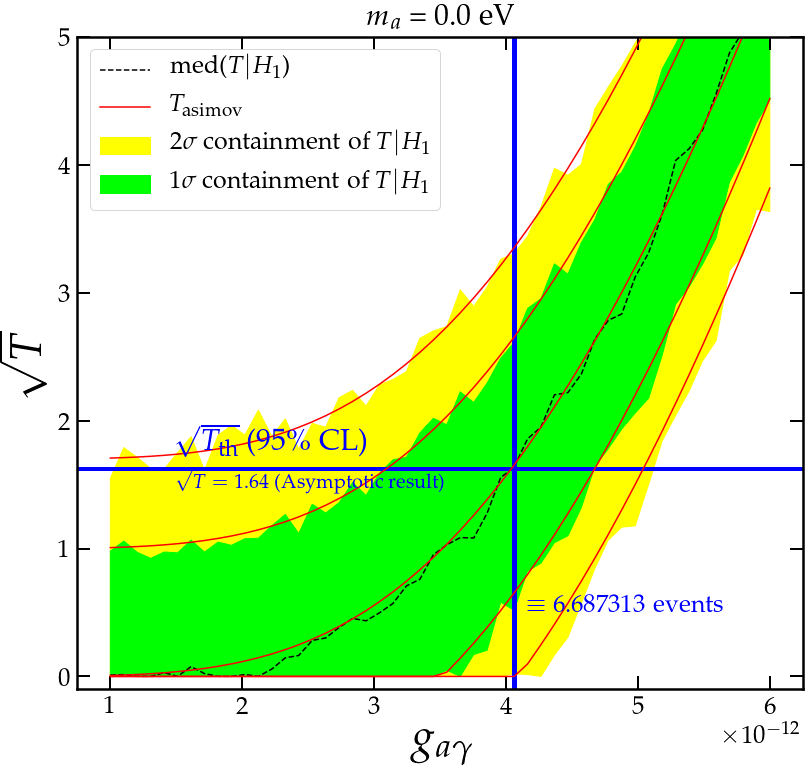

In [4]:
fig,ax = MySquarePlot(r'$g_{a\gamma}$',r'$\sqrt{T}$')

plt.plot(gvals,sqrt(T1_50),'k--',label='med($T|H_1$)')

# True monte carlo Containment band:
plt.fill_between(gvals,sqrt(T1_05),y2=sqrt(T1_95),color='yellow',label=r'2$\sigma$ containment of $T|H_1$')
plt.fill_between(gvals,sqrt(T1_16),y2=sqrt(T1_84),color='lime',label=r'1$\sigma$ containment of $T|H_1$')


# Median exclusion 95% cl => 1.64 sigma (for 1/2 chi^2 null hypothesis distribution)
T0_95 = sort(T0)[int(0.95*n_expts)]
plt.axhline(sqrt(T0_95),color='b',lw=3)
plt.axhline(1.64,color='b',lw=1)
      

# Also plot the coupling this 95% exclusion would correspond to
g95_med = gvals[argmin(abs(T0_95-T1_50))]
plt.axvline(g95_med,color='b',lw=5)

# Plot approximate T values and containent from Asimov data:
plt.plot(gvals,sqrt(T1_asimov),'r-',label=r'$T_{\rm asimov}$')
plt.plot(gvals,sqrt(T1_asimov)+1,'r-') # 1 sigma upper
plt.plot(gvals,maximum(0,sqrt(T1_asimov)-1),'r-') # 1 sigma lower
plt.plot(gvals,maximum(0,sqrt(T1_asimov)-1.7),'r-') # 2 sigma lower (approx)
plt.plot(gvals,sqrt(T1_asimov)+1.7,'r-') # 2 sigma upper (approx)

# Tweaking
plt.legend()
plt.text(1.5e-12,sqrt(T0_95)+0.1,r'$\sqrt{T_{\rm th}}$ (95\% CL)',color='blue',fontsize=30)
plt.text(1.5e-12,1.64-0.17,r'$\sqrt{T}=1.64$ (Asymptotic result)',color='blue',fontsize=20)
plt.title(r'$m_a$ = '+str(m_a)+' eV')
plt.ylim([0,5])



# Overplot an event number for convenience
N_events = sum(Signal_10[:,0])*(g95_med/1e-10)**4.0
plt.text(g95_med+0.1e-12,0.5,r'$\equiv$ '+str('{0:0f}'.format(N_events))+' events',color='b')

plt.ylim(bottom=-0.1)

MySaveFig(fig,'IAXO_AsimovValidation')

# Not bad, for this particular mass, now we want to check the limits come out right too.

## We repeat the process for a range of masses to calculate the sensitivity 

First we set up the tables of Photon numbers for the "AllModes" strategy then we use the ProfileLikelihood routines in Like.py to calculate the sensitivities

In [5]:
# Range of masses
nm = 1000
m_vals = logspace(-6.1,0.1,nm)

# Energy binning
nfine = 10
nE_bins = 500
Ei,E_bins = EnergyBins(10e-3,20.0,nfine,nE_bins)

# Just do Primakoff Signal for this figure:
Flux10 = AxionFlux_Primakoff_PlasmonCorrection(1e-10,Ei)
Signal_10,R0 = BinnedPhotonNumberTable_AllModes(m_vals,Ei,E_bins,Flux10,Exposure_total=6.0,res_on=True)

# Background
Background = BinnedBackgroundEvents(Ei,E_bins,background_level=1e-8)

In [6]:
# Asimov sensitivity:
n_DL = 500
m_DL_vals = logspace(-6,0,n_DL)
DL = ProfileLikelihood_Sensitivity(m_DL_vals,m_vals,Signal_10,Background)

In [7]:
# Monte carlo simulate the 95% CL sensitivity:
DL_MC = ProfileLikelihood_Sensitivity_MonteCarlo(m_DL_vals,m_vals,Signal_10,Background)

0 4.456250981589519e-12
1 4.674358382213947e-12
2 4.419036673470726e-12
3 4.450712868644155e-12
4 4.527195780057188e-12
5 4.460433637347246e-12
6 4.468898919876586e-12


../src/Like.py:120: RuntimeWarning: divide by zero encountered in log
  return sum(Nob*log(Nex) - Nex)# - gammaln(Nob+1.0)) #factorial removed for speed
../src/Like.py:120: RuntimeWarning: invalid value encountered in multiply
  return sum(Nob*log(Nex) - Nex)# - gammaln(Nob+1.0)) #factorial removed for speed


7 4.422616266463938e-12
8 4.509501663313268e-12
9 4.478302895998519e-12
10 4.320648629377246e-12
11 4.493768948829826e-12
12 4.413459682075345e-12
13 4.499872560692911e-12
14 4.543151261252072e-12
15 4.504200114116344e-12
16 4.438453058118121e-12
17 4.343868680677606e-12
18 4.590115898436017e-12
19 4.525881275844724e-12
20 4.399265765461832e-12
21 4.4451233580381186e-12
22 4.36752337696414e-12
23 4.530731583118819e-12
24 4.488834047924268e-12
25 4.476091197281831e-12
26 4.421472637712675e-12
27 4.460714636478524e-12
28 4.432887435639729e-12
29 4.459290517759809e-12
30 4.588501492945216e-12
31 4.537198017912179e-12
32 4.4406519699146e-12
33 4.47707320597089e-12
34 4.397194860149498e-12
35 4.524547294159546e-12
36 4.4989984711098625e-12
37 4.555496048088067e-12
38 4.346775966931636e-12
39 4.341232263894711e-12
40 4.41726935279872e-12
41 4.46241299818262e-12
42 4.376141281133898e-12
43 4.36314967419477e-12
44 4.50349677676095e-12
45 4.365972287328048e-12
46 4.616169050695199e-12
47 4.4806

325 4.6226214589852e-12
326 4.578084654837202e-12
327 4.628252188946685e-12
328 4.617656279896393e-12
329 4.5805547885488265e-12
330 4.664500996734279e-12
331 4.637567768399189e-12
332 4.598215560582538e-12
333 4.724742968798649e-12
334 4.64289263746454e-12
335 4.758280411877186e-12
336 4.86938992157839e-12
337 4.950382513167775e-12
338 4.8726384987922215e-12
339 4.940586311050866e-12
340 5.05301752054779e-12
341 5.003489660247245e-12
342 5.207498557520588e-12
343 5.22499405377177e-12
344 5.058323954720909e-12
345 5.333314410624987e-12
346 5.46798275722116e-12
347 5.567993338673713e-12
348 5.6849582673369466e-12
349 5.650343174358644e-12
350 5.855111400021888e-12
351 6.0628233887207535e-12
352 5.87778816080933e-12
353 5.975046552858868e-12
354 6.213323211282139e-12
355 6.6875914095735935e-12
356 6.608639666079208e-12
357 7.1352119653988486e-12
358 7.084531195672389e-12
359 7.532040143470558e-12
360 7.644425186744546e-12
361 8.069462744192119e-12
362 8.082736617978922e-12
363 8.62444611

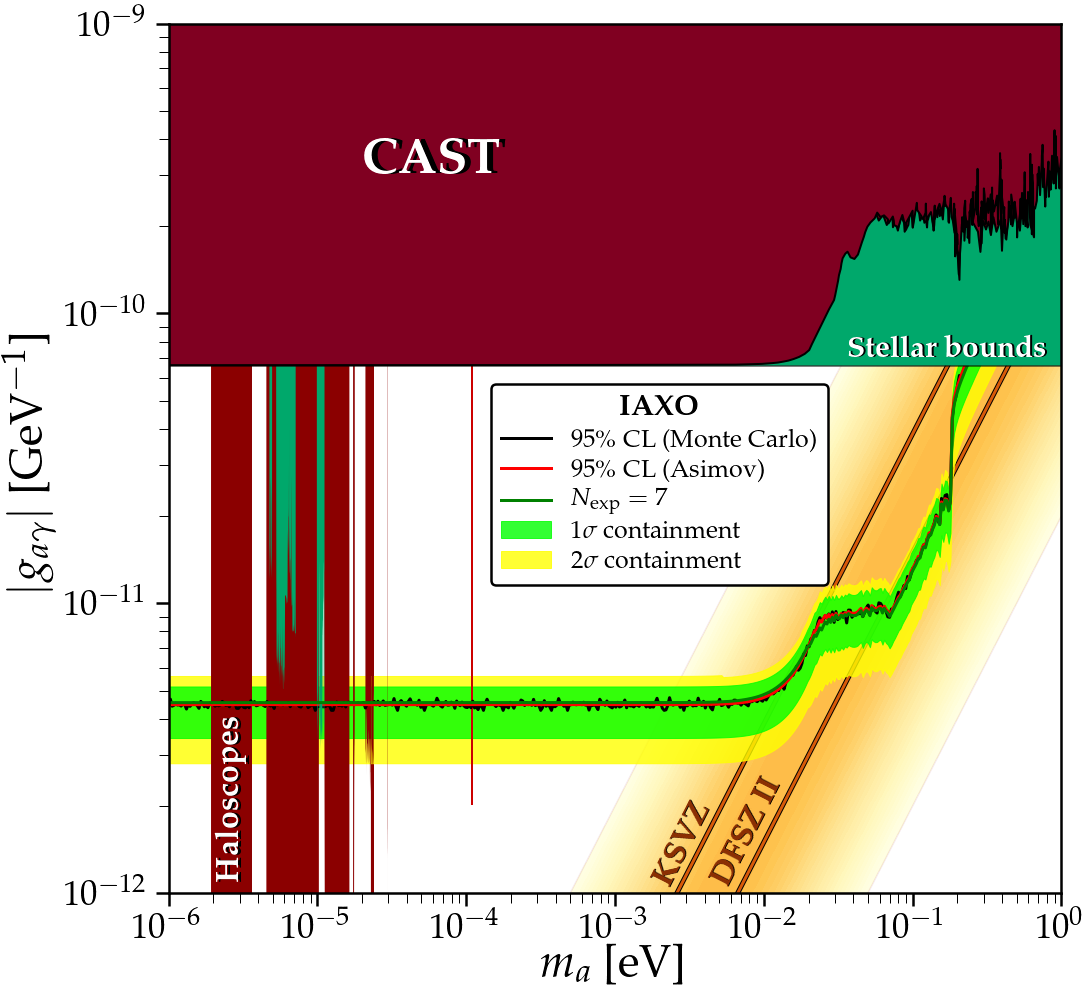

In [14]:
fig,ax = AxionPlotSetup()

# Plot lines
plt.plot(m_DL_vals,DL_MC,'k-',lw=3,zorder=0.1,label=r'95\% CL (Monte Carlo)')
plt.plot(m_DL_vals,DL[0,:],'r-',lw=3,zorder=0.1,label=r'95\% CL (Asimov)')
plt.fill_between(m_DL_vals,DL[1,:],y2=DL[2,:],color='lime',zorder=0.02,label='$1\sigma$ containment',alpha=0.8)
plt.fill_between(m_DL_vals,DL[3,:],y2=DL[4,:],color='yellow',zorder=0.01,label='$2\sigma$ containment',alpha=0.8)

# Plot a N_events = 7 line which seems to be another good approximation:
IAXO_approx = ConstantObsNumberLine(7,m_DL_vals,m_vals,Signal_10) # Primakoff 
plt.plot(m_DL_vals,IAXO_approx,'g-',lw=3,label=r'$N_{\rm exp} = 7$',zorder=0.11)


# Final tweaking of legend
leg = plt.legend(fontsize=25,frameon=True,title=r'{\bf IAXO}',loc='center',framealpha=1,edgecolor='k',labelspacing=0.2,bbox_to_anchor=(0.55,0.47))
plt.setp(leg.get_title(),fontsize=30)
leg.get_frame().set_linewidth(2.5)

MySaveFig(fig,'IAXO_Sensitivity_Asimov')